### Timeseries inside and out of polynyas

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 
import pandas as pd
from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath

### Get the CESM2 4p4z tseries files 

In [2]:
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005'
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'
variables = ['spC','coccoC','diatC','zoo1C','zoo2C','zoo3C','zoo4C',
             'x_graze_zoo1_zint','x_graze_zoo2_zint','x_graze_zoo3_zint','x_graze_zoo4_zint',
             'photoC_TOT_zint', 'photoC_diat_zint', 'photoC_sp_zint', 'photoC_cocco_zint',
            'IFRAC']

In [3]:
%%time
ds_list = []
print(f'reading {case}')
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.006201-012212.nc'))       
    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

reading g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.4p4z.005
spC
coccoC
diatC
zoo1C
zoo2C
zoo3C
zoo4C
x_graze_zoo1_zint
x_graze_zoo2_zint
x_graze_zoo3_zint
x_graze_zoo4_zint
photoC_TOT_zint
photoC_diat_zint
photoC_sp_zint
photoC_cocco_zint
IFRAC
CPU times: user 7.87 s, sys: 427 ms, total: 8.3 s
Wall time: 16.5 s


In [4]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

### trim latitude to the same length as polynas and fix time

In [5]:
ds = ds.isel(nlat=slice(0,76))

In [6]:
#fix time dimension so it's a mean of the timebounds
ds["time"] = ds.time_bound.compute().mean(dim="d2")

### Get coords

In [7]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
ds_grid = ds_grid.isel(nlat=slice(0,76))
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4

ds['z_t']=ds_grid.z_t
depths_m=ds_grid.z_t * 0.01
dz=ds_grid.dz
dz_m=ds_grid.dz * 0.01
tlen=len(ds.time)

### Make the biological variables 2-D

In [8]:
tmp = ds.zoo1C * 10.
ds['zoo1C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo2C * 10.
ds['zoo2C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo3C * 10.
ds['zoo3C_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.zoo4C * 10.
ds['zoo4C_zint'] = tmp.sum(dim='z_t_150m')

ds['zooC_TOT_zint'] = ds['zoo1C_zint'] + ds['zoo2C_zint'] + ds['zoo3C_zint'] + ds['zoo4C_zint']

tmp = ds.spC * 10.
ds['spC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.diatC * 10.
ds['diatC_zint'] = tmp.sum(dim='z_t_150m')
tmp = ds.coccoC * 10.
ds['coccoC_zint'] = tmp.sum(dim='z_t_150m')

ds['phytoC_TOT_zint'] = ds['spC_zint'] + ds['diatC_zint'] + ds['coccoC_zint']

Drop the 3-D vars now

In [9]:
ds = ds.drop(['spC','coccoC','diatC','zoo1C','zoo2C','zoo3C','zoo4C'])
ds  = ds.drop(['z_t','z_t_150m'])

### update the variable list

In [10]:
#redefine variable list
variables = ['spC_zint'] # 'spC_zint','coccoC_zint','diatC_zint','zoo1C_zint','zoo2C_zint','zoo3C_zint','zoo4C_zint',
             #'x_graze_zoo1_zint','x_graze_zoo2_zint','x_graze_zoo3_zint','x_graze_zoo4_zint',
             #'photoC_TOT_zint', 'photoC_diat_zint', 'photoC_sp_zint', 'photoC_cocco_zint',
            #'IFRAC','phytoC_TOT_zint','zooC_TOT_zint']

### Get polynya masks

#### 0 = not a polynya
#### 1 = open water polynya
#### 2 = coastal polynya


In [11]:
# thres_var='aice'
# thres = '25%'

# thres_var='hi'
# thres = '0.8m'

thres_var='hi'
thres = '0.22m'

path = '/glade/p/cesm/pcwg/landrum/' + case + '/ice/polynyas/monthly/'

In [12]:
file = path + case + '.' + thres_var + '_' + thres + 'thresh.polynya_sh.006201-012212.nc'

ds_poly = xr.open_dataset(file, drop_variables=["transport_components", "transport_regions"], decode_times=True)

### rename the coords so they match

In [13]:
ds_poly = ds_poly.rename({'lon': 'nlon','lat': 'nlat'})

In [14]:
ds_poly['time'] = ds.time

In [15]:
ds['polynyas'] = ds_poly['polynyas']

#### make a deciyear var for plotting monthly timeseries

In [16]:
deciyear = np.full((732),np.nan)
i=0
for year in np.arange(1958,2019,1):
    
    for month in np.arange(1,13):
        
        #print(i,year, month,year + month/12. - (1./24.))
        deciyear[i] = year + month/12. - (1./24.)
        
        i = i+1

### make sure that land is nan

In [17]:
ds  = ds.where(ds_grid.REGION_MASK>0)

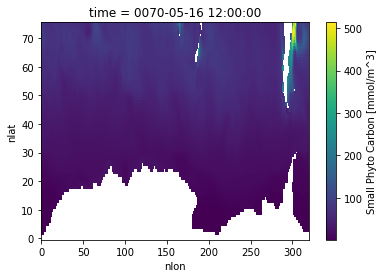

In [18]:
ds.spC_zint.isel(time=100).plot()

#### function to adjust POP grid for map making

In [19]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [20]:
ds['TOT_zoo_prod_zint'] = ds.x_graze_zoo1_zint + ds.x_graze_zoo2_zint + ds.x_graze_zoo3_zint + ds.x_graze_zoo4_zint
ds['z-ratio'] = (ds.x_graze_zoo3_zint + ds.x_graze_zoo4_zint)/ ds.photoC_TOT_zint

variables = variables + ['TOT_zoo_prod_zint','z-ratio']

In [21]:
ds

<xarray.Dataset>
Dimensions:            (d2: 2, nlat: 76, nlon: 320, time: 732, z_t: 60)
Coordinates:
    TLAT               (nlat, nlon) float64 dask.array<chunksize=(76, 320), meta=np.ndarray>
    TLONG              (nlat, nlon) float64 dask.array<chunksize=(76, 320), meta=np.ndarray>
  * time               (time) object 0062-01-16 12:00:00 ... 0122-12-16 12:00:00
Dimensions without coordinates: d2, nlat, nlon, z_t
Data variables:
    KMT                (nlat, nlon) float64 dask.array<chunksize=(76, 320), meta=np.ndarray>
    REGION_MASK        (nlat, nlon) float64 dask.array<chunksize=(76, 320), meta=np.ndarray>
    TAREA              (nlat, nlon) float64 dask.array<chunksize=(76, 320), meta=np.ndarray>
    dz                 (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 76, 320), meta=np.ndarray>
    time_bound         (time, d2, nlat, nlon) object dask.array<chunksize=(732, 2, 76, 320), meta=np.ndarray>
    x_graze_zoo1_zint  (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    x_graze_zoo2_zint  (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    x_graze_zoo3_zint  (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    x_graze_zoo4_zint  (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    photoC_TOT_zint    (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    photoC_diat_zint   (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    photoC_sp_zint     (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    photoC_cocco_zint  (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    IFRAC              (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    zoo1C_zint         (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    zoo2C_zint         (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    zoo3C_zint         (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    zoo4C_zint         (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    zooC_TOT_zint      (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    spC_zint           (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    diatC_zint         (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    coccoC_zint        (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    phytoC_TOT_zint    (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    polynyas           (time, nlat, nlon) float64 nan nan nan ... 0.0 0.0 0.0
    TOT_zoo_prod_zint  (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>
    z-ratio            (time, nlat, nlon) float32 dask.array<chunksize=(732, 76, 320), meta=np.ndarray>

In [22]:
lon, lat, field = adjust_pop_grid(lons, lats, ds.TOT_zoo_prod_zint.isel(time=384) * 864.)
lon, lat, ice = adjust_pop_grid(lons, lats, ds.IFRAC.isel(time=384))
lon, lat, polycoast = adjust_pop_grid(lons, lats, ds.polynyas.isel(time=384))

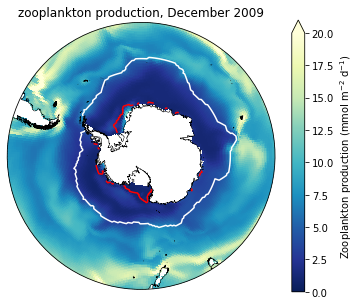

In [23]:
fig = plt.figure(figsize=(6,5))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('zooplankton production, December 2009')
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=0, vmax=20, 
                 cmap='YlGnBu_r',
                 transform=ccrs.PlateCarree())

pci=ax.contour(lon, lat, ice, 
                 levels=[15], 
                 colors='white',
                 transform=ccrs.PlateCarree())

pci=ax.contour(lon, lat, polycoast, 
                 levels=[2], 
                 colors='red',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='Zooplankton production (mmol m$^{-2}$ d$^{-1}$)')

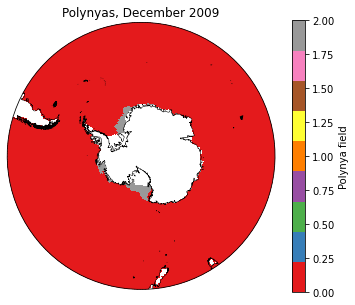

In [24]:
fig = plt.figure(figsize=(6,5))
#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('Polynyas, December 2009')
ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle
ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, polycoast,
                 vmin=0, vmax=2, 
                 cmap='Set1',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,label='Polynya field')

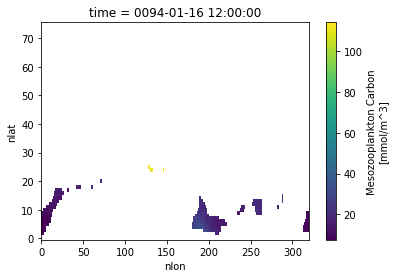

In [25]:
ds['zoo3C_zint'].isel(time=384).where(ds['polynyas'].isel(time=384)>=1.).plot()

### make monthly timeseries of coastal polynyas


In [26]:
### redefine variable list for testing purposes
variables = ['zoo3C_zint'] 

In [27]:
%%time
ts_coastal_polys = xr.Dataset({v: ds[v] for v in ['time']})

for var in variables:

    masked = ds[var].where(ds['polynyas']==2.)

    ts_coastal_polys[var] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute()

CPU times: user 23.9 s, sys: 3.28 s, total: 27.2 s
Wall time: 54.1 s


### make monthly timeseries of open water polynyas

In [28]:
%%time
ts_open_polys = xr.Dataset({v: ds[v] for v in ['time']})

for var in variables:

    masked = ds[var].where(ds['polynyas']==1.)

    ts_open_polys[var] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute()

CPU times: user 23.7 s, sys: 3.22 s, total: 26.9 s
Wall time: 53.6 s


### make monthly timeseries of non-polynyas in SIZ

In [29]:
%%time
ts_nonpolys = xr.Dataset({v: ds[v] for v in ['time']})

for var in variables:

    masked = ds[var].where(ds['IFRAC']>0.15).where(ds['polynyas']==0)

    ts_nonpolys[var] = esmlab.weighted_mean(masked, weights=area_m, dim=['nlat', 'nlon']).compute()

CPU times: user 24.2 s, sys: 3.33 s, total: 27.5 s
Wall time: 55.1 s


In [30]:
ts_open_polys.zoo3C_zint.values

array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,  12.13825321,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,  12.40086746,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,  61.4547562 ,
                nan,          nan,          nan,          nan,
        33.66036224,          nan,          nan,          nan,
                nan,          nan,  45.48077774,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,       

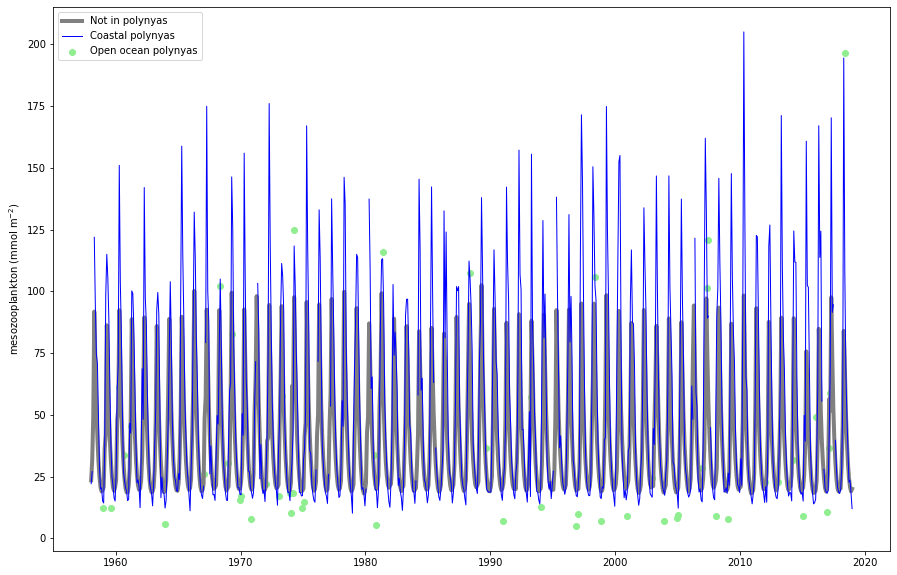

In [31]:
#style.use('ggplot')
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(15,10))
#fig.suptitle('Southern Ocean, ${\sigma}_{\Theta}$ 26 to 27 surface outcrop')

ax.set_ylabel('mesozooplankton (mmol m$^{-2}$)')
ax.plot(deciyear, 
         ts_nonpolys['zoo3C_zint'], 
         color='gray', label='Not in polynyas',linewidth=4)
ax.scatter(deciyear, 
         ts_open_polys['zoo3C_zint'], 
         color='lightgreen', label='Open ocean polynyas')
ax.plot(deciyear, 
         ts_coastal_polys['zoo3C_zint'], 
         color='blue', label='Coastal polynyas',linewidth=1)

ax.legend();

### make timeseries of annual means for coastal polynyas and non-polynas
#### (there aren't really enough open ocean polynyas for making annual means)

In [32]:
%%time
ts_nonpolys_annual = ts_nonpolys.resample({'time':'A'}).mean(dim='time').compute()

CPU times: user 39.2 ms, sys: 2.63 ms, total: 41.9 ms
Wall time: 279 ms


In [33]:
%%time
ts_coastal_polys_annual = ts_coastal_polys.resample({'time':'A'}).mean(dim='time').compute()

CPU times: user 34.3 ms, sys: 0 ns, total: 34.3 ms
Wall time: 59.9 ms


In [34]:
years = np.arange(1958,2019,1)

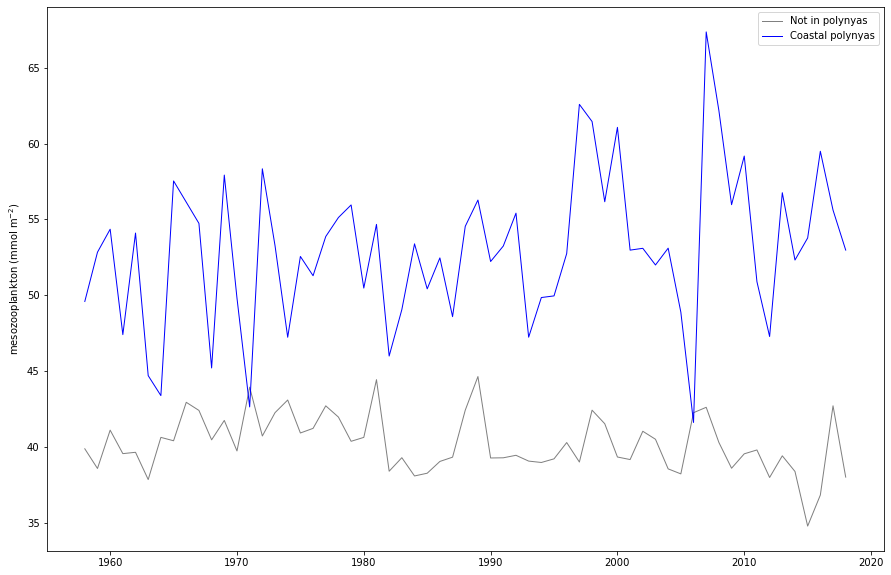

In [35]:
#style.use('ggplot')
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(15,10))
#fig.suptitle('Southern Ocean, ${\sigma}_{\Theta}$ 26 to 27 surface outcrop')

ax.set_ylabel('mesozooplankton (mmol m$^{-2}$)')
ax.plot(years, 
         ts_nonpolys_annual['zoo3C_zint'], 
         color='gray', label='Not in polynyas',linewidth=1)
ax.plot(years, 
         ts_coastal_polys_annual['zoo3C_zint'], 
         color='blue', label='Coastal polynyas',linewidth=1)

ax.legend();

## plot with :
thres_var='hi'
thres = '0.8m'

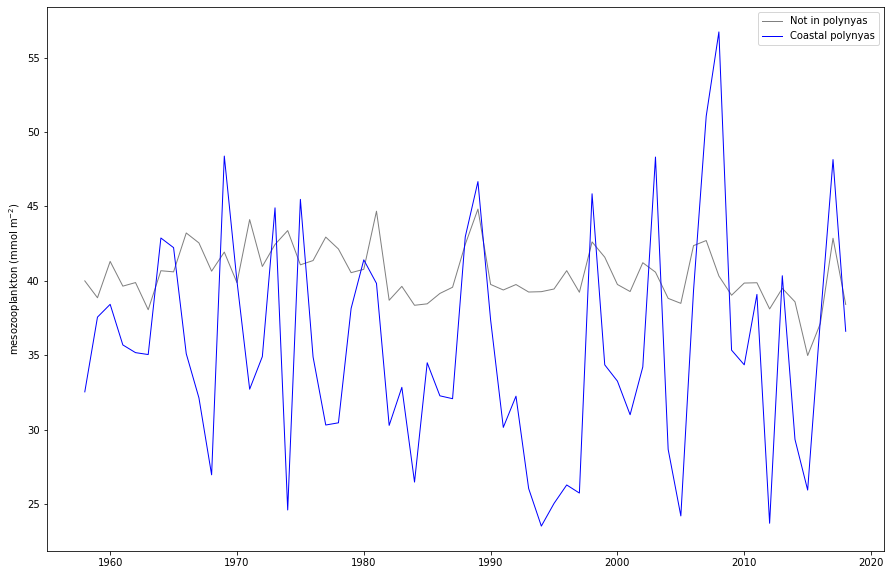

In [73]:
#style.use('ggplot')
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(15,10))
#fig.suptitle('Southern Ocean, ${\sigma}_{\Theta}$ 26 to 27 surface outcrop')

ax.set_ylabel('mesozooplankton (mmol m$^{-2}$)')
ax.plot(years, 
         ts_nonpolys_annual['zoo3C_zint'], 
         color='gray', label='Not in polynyas',linewidth=1)
ax.plot(years, 
         ts_coastal_polys_annual['zoo3C_zint'], 
         color='blue', label='Coastal polynyas',linewidth=1)

ax.legend();